In [1]:
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
import pickle
import scipy.interpolate
import scipy.misc

from scipy.ndimage.filters import gaussian_filter1d

from ultrasoundData import UltrasoundData

udata = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack.pickle")
udata.makeData()

udata2 = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack2.pickle")
udata2.makeData()

In [3]:
udata3 = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack3.pickle")
udata3.makeData()
traindata = np.concatenate([udata3.data, udata2.data, udata.data[:50000]])
testdata = udata.data[50000:].copy()

trainclasses = np.concatenate([udata3.classes, udata2.classes, udata.classes[:50000]])[:,0]
testclasses = udata.classes[50000:].copy()[:,0]


In [12]:
from keras.models import Sequential
traindata.dtype

dtype('float64')

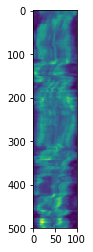

ValueError: could not broadcast input array from shape (170000,90) into shape (170000,100)

In [7]:


import matplotlib.pyplot as plt
plt.imshow(np.sum(testdata, 1)[1000:1500,:,0])
plt.show()

def project(data):
    ret = np.zeros((data.shape[0], data.shape[2], 3), dtype=np.float64)
    #ret[:, :, 0] = np.sum(data, 1)[:,:,0] / np.max(np.sum(data, 1)[:,:,0])
    ret[:, :, 0] = np.max(data, 1)[:,10:,0] 
    ret[:, :, 1] = np.argmax(data, 1)[:,10:,0] / 100.
    
    return ret

traindataprocessed=project(traindata)
testdataprocessed=project(testdata)
    
plt.imshow(project(testdata[:200]))
plt.show()

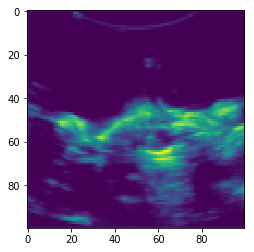

In [9]:
plt.imshow(testdata[400, :, :, 0])
plt.show()

In [57]:
s_testclasses = s_testclasses[:, :1]
testclasses.shape
s_trainclasses = s_trainclasses[:, :1]
testclasses.shape

(710, 1)

In [32]:
def stagger(data, classes, n):
    stagger_data = [
        data[i:i + 2 * n + 1]
        for i in range(0, len(data) - 2 * n,14)
    ]
    
    stagger_classes = classes[n:-n:14]
    
    stagger_data = np.array(stagger_data)
    
    
    return stagger_data, stagger_classes

s_traindata, s_trainclasses = stagger(traindataprocessed, trainclasses, 30)
s_testdata, s_testclasses = stagger(testdataprocessed, testclasses, 30)

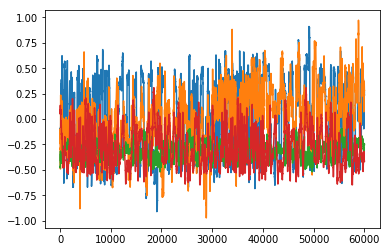

In [33]:
plt.plot(udata.classes)
plt.show()

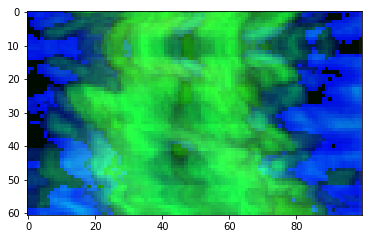

In [38]:
plt.imshow(s_traindata[8])
plt.show()

In [39]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers

In [61]:


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(61, 100, 3)
                 
                ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.6))
model.add(Dense(1, activation='tanh'))

"""
import keras.backend as K
#def logLikelyhoodLoss(x_pred, x_true):
#    return (.1 * -K.mean(-(x_pred[:, 0] - x_true[:, 0])**2 / ( (1 + x_pred[:, 1] )) - K.log(np.pi *(1 + x_pred[:, 1])), -1)
#            + K.mean(K.abs(x_pred[:, 0] - x_true[:, 0]), -1))

def logLikelyhoodLoss(x_pred, x_true):
    return -K.mean(-K.sqrt((x_pred[:, 0] - x_true[:, 0])**2), -1)"""

'\nimport keras.backend as K\n#def logLikelyhoodLoss(x_pred, x_true):\n#    return (.1 * -K.mean(-(x_pred[:, 0] - x_true[:, 0])**2 / ( (1 + x_pred[:, 1] )) - K.log(np.pi *(1 + x_pred[:, 1])), -1)\n#            + K.mean(K.abs(x_pred[:, 0] - x_true[:, 0]), -1))\n\ndef logLikelyhoodLoss(x_pred, x_true):\n    return -K.mean(-K.sqrt((x_pred[:, 0] - x_true[:, 0])**2), -1)'

In [62]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.adam(lr=.001))

In [63]:

#del udata.data, udata2.data, udata3.data
model.fit(s_traindata, 
          s_trainclasses,
          batch_size=200,
          epochs=30,
          verbose=1,
          validation_data=(s_testdata, s_testclasses))

Train on 12139 samples, validate on 710 samples
Epoch 1/30
12139/12139 [==============================] - 3s - loss: 0.1109 - val_loss: 0.1061
Epoch 2/30
12139/12139 [==============================] - 3s - loss: 0.1013 - val_loss: 0.1184
Epoch 3/30
12139/12139 [==============================] - 3s - loss: 0.0768 - val_loss: 0.1026
Epoch 4/30
12139/12139 [==============================] - 3s - loss: 0.0618 - val_loss: 0.1267
Epoch 5/30
12139/12139 [==============================] - 3s - loss: 0.0534 - val_loss: 0.1243
Epoch 6/30
12139/12139 [==============================] - 3s - loss: 0.0496 - val_loss: 0.1378
Epoch 7/30
12139/12139 [==============================] - 3s - loss: 0.0441 - val_loss: 0.1394
Epoch 8/30
12139/12139 [==============================] - 3s - loss: 0.0392 - val_loss: 0.1455
Epoch 9/30
12139/12139 [==============================] - 3s - loss: 0.0360 - val_loss: 0.2155
Epoch 10/30
12139/12139 [==============================] - 3s - loss: 0.0312 - val_loss: 0.1820
E

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
plt.scatter(s_testclasses[:20000][:,0] , s_model.predict(testdata[:20000])[:,0], 1)
#plt.plot([-1, 1], [-1, 1])
plt.show()

NameError: name 's_testclasses' is not defined

In [13]:
import scipy.signal


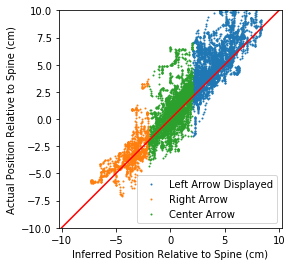

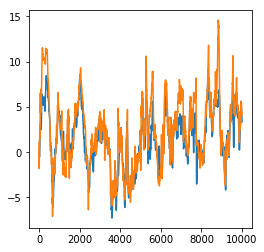

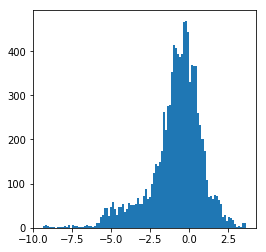

In [14]:
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = [4, 4]
guess = model.predict(testdata)[:, 1] * 15
guess = scipy.signal.medfilt(guess, 31)
highmask = guess > 2.0
lowmask = guess < -2.0

midmask = np.logical_not(np.logical_or(highmask, lowmask))


plt.axis('equal')
left = plt.scatter(guess[highmask], testclasses[highmask, 1] * 15, 1)
right = plt.scatter(guess[lowmask], testclasses[lowmask, 1] * 15, 1)
stay = plt.scatter(guess[midmask], testclasses[midmask, 1] * 15, 1)
plt.legend((left, right, stay), ("Left Arrow Displayed", "Right Arrow", "Center Arrow"))
plt.xlabel("Inferred Position Relative to Spine (cm)")
plt.ylabel("Actual Position Relative to Spine (cm)")
span=10
plt.plot([-span, span], [-span, span], "red")
plt.axis('equal')
plt.axis([-span, span, -span, span])
plt.show()
plt.plot(guess)
plt.plot(testclasses[:, 1] * 15)
plt.show()
plt.hist(guess - testclasses[:, 1] * 15, 100)
plt.show()

In [24]:
keras.models.save_model(model, "GotMeMovingSideToSide.hd5y")

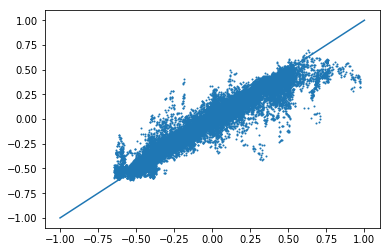

In [12]:
import matplotlib.pyplot as plt
plt.scatter(udata.classes[50000:] , model.predict(udata.data[50000:]), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

In [1]:
import matplotlib.pyplot as plt
plt.plot(-tdata.classes[:, 0])
plt.plot(model.predict(tdata.data)[:, 0])
plt.plot([-1, 1], [-1, 1])
plt.show()

NameError: name 'tdata' is not defined

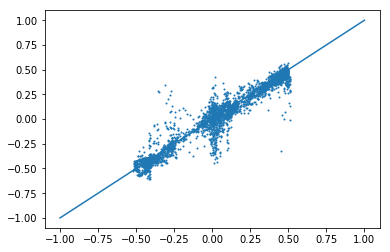

In [14]:
plt.scatter(udata.classes[57000:].flatten() , model.predict(udata.data[57000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

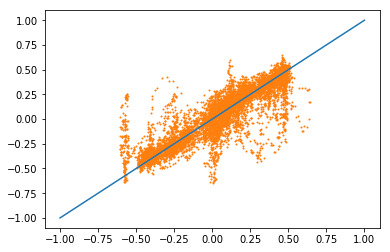

In [20]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

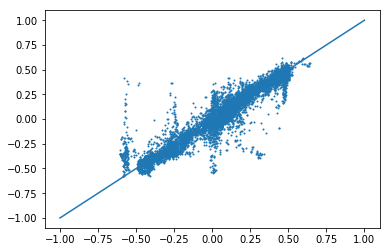

In [11]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

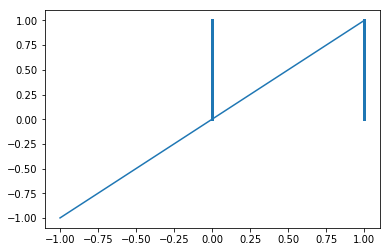

In [30]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

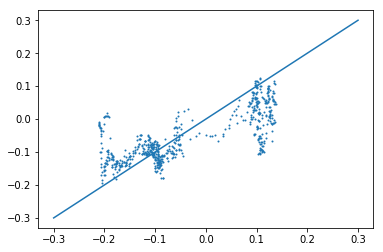

In [28]:
plt.scatter(udata.classes[6000:6600].flatten() , model.predict(udata.data[6000:6600]).flatten(), 1)
plt.plot([-.3, .3], [-.3, .3])
plt.show()

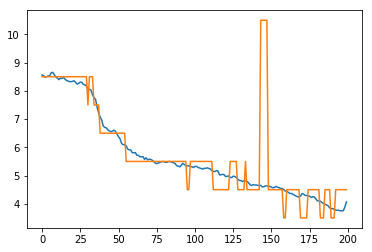

In [29]:
offset = 59000
length = 200

plt.plot(udata.angles[offset:offset + length])

plt.plot(np.argmax(model.predict(udata.data[offset:offset + length]), 1) + .5)
plt.show()

In [1]:

length = 1000
offset = 3000
plt.plot(testclasses[offset:offset + length])
plt.plot(model.predict(testdata[offset:offset + length]).flatten())
plt.show()

NameError: name 'plt' is not defined

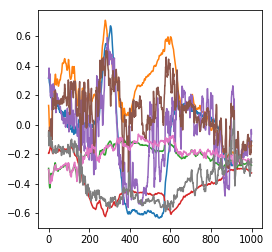

In [16]:

length = 1000
offset = 5000
plt.plot(testclasses[offset:offset + length])
plt.plot(model.predict(testdata[offset:offset + length]))
plt.show()

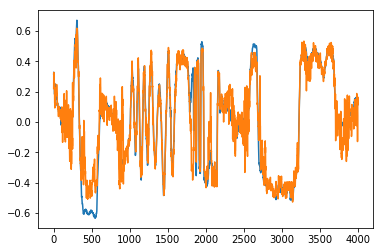

In [39]:

length = 4000
offset = 5000
plt.plot(testclasses[offset:offset + length, 0])
plt.plot(model.predict(testdata[offset:offset + length])[:, 0])
plt.show()

In [5]:
plt.imshow(udata3.data[59600, :, :, 0])
plt.show()

NameError: name 'udata3' is not defined

In [106]:
td.shape

(100, 100, 100, 1)

In [107]:
tc.shape

(100, 2)

In [14]:
import h5py

In [18]:
h5py.run_tests()

.....................................................x...............................s...................................x....................................s........ss.ss...........................................................................ss...................ssssss.................................................................x....x........................x.....x......................................ssssssssss...............
----------------------------------------------------------------------
Ran 439 tests in 1.105s

OK (skipped=24, expected failures=6)


<unittest.runner.TextTestResult run=439 errors=0 failures=0>

In [25]:
f = model.layers[0]

In [26]:
w = f.weights[0]

In [27]:
a, b = f.get_weights()

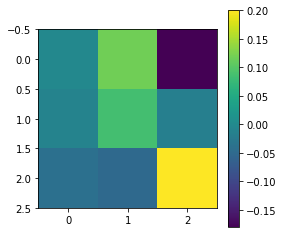

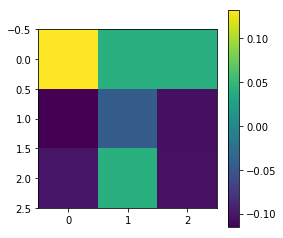

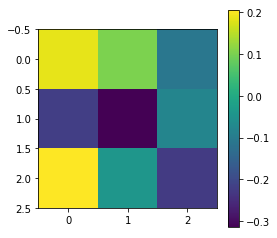

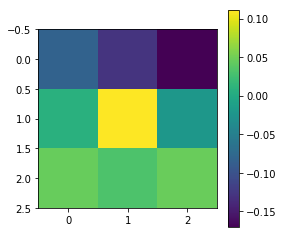

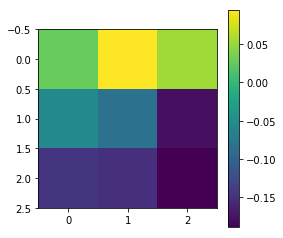

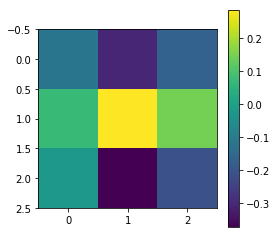

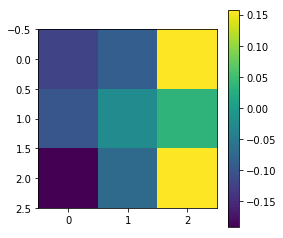

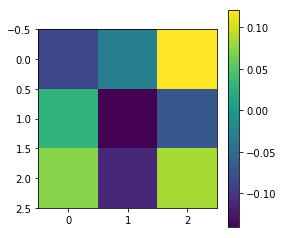

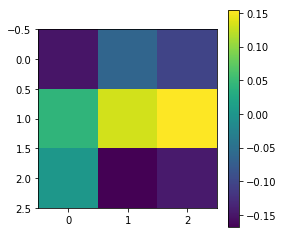

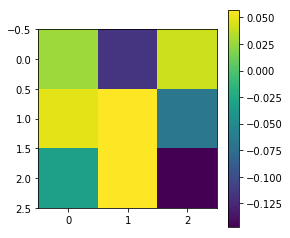

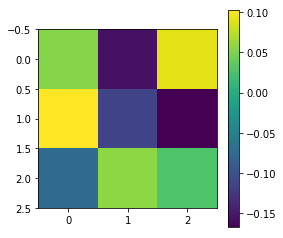

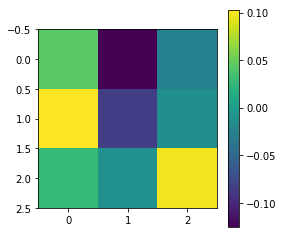

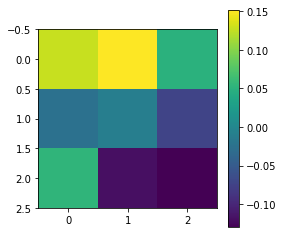

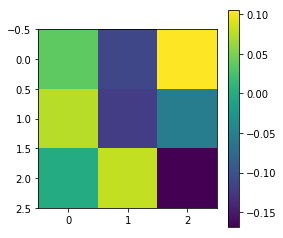

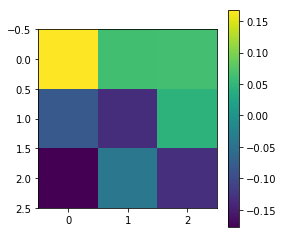

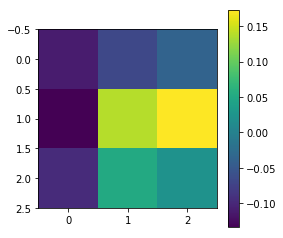

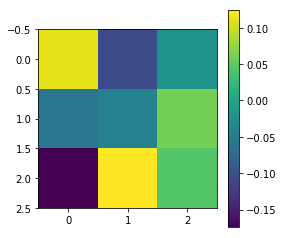

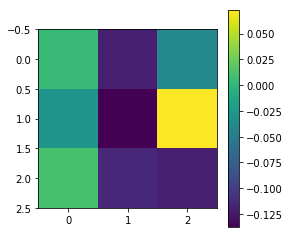

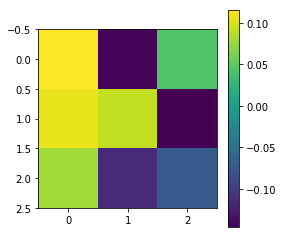

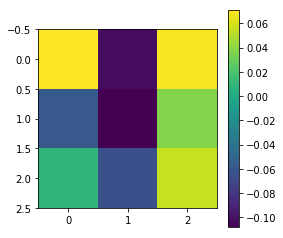

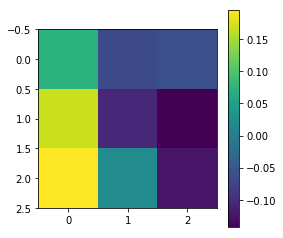

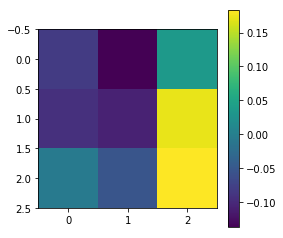

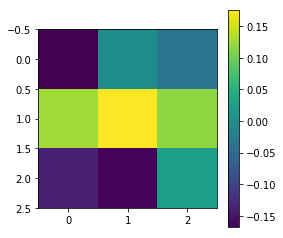

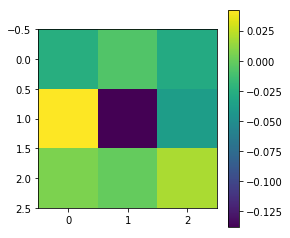

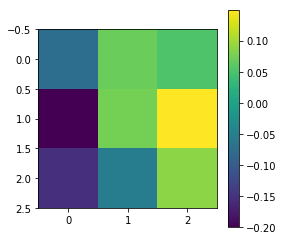

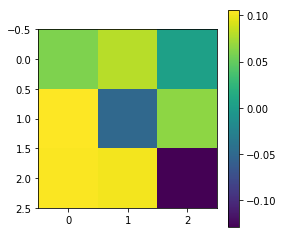

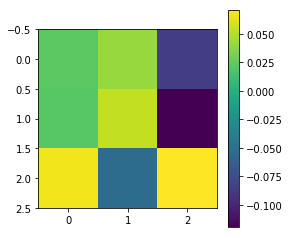

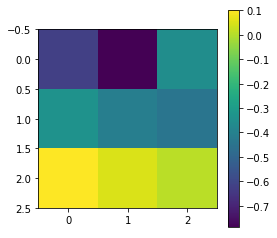

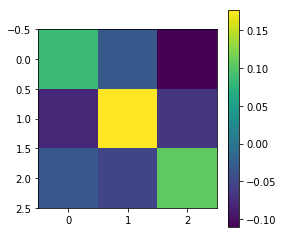

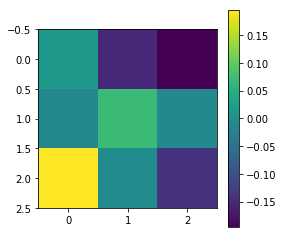

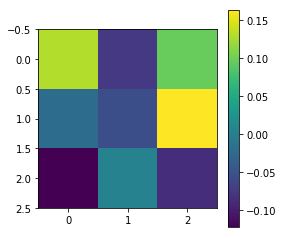

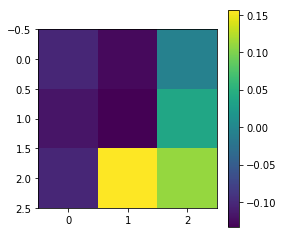

In [28]:
for i in range(32):
    
    plt.imshow(a[:,:,0,i])
    plt.colorbar()
    plt.show()

In [29]:
np.min(udata.classes)

-0.97224527308341391

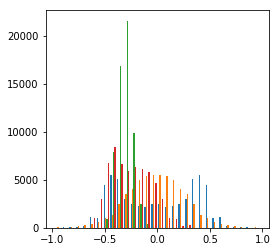

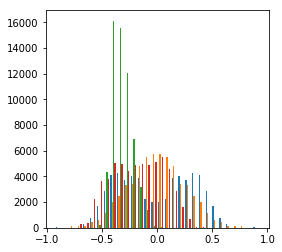

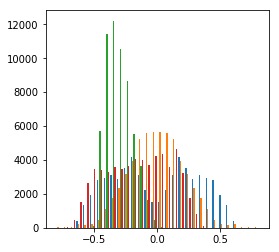

In [30]:
plt.hist(udata.classes, 30)
plt.show()
plt.hist(udata2.classes, 30)
plt.show()
plt.hist(udata3.classes, 30)
plt.show()

In [5]:
#model.pop()
#model.pop()
#model.pop()

model=keras.models.load_model("dataProcessor")

In [6]:

testdataProcessed = model.predict(testdata)
traindataProcessed = model.predict(traindata)

In [7]:
model.predict(testdata[0:1])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.08859286,  0.06565258,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.05281679,  0.        ,
         0.        ,  0.        ,  0.18645032,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.1

In [18]:
for layer in model.layers:
    print(layer.name)


conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
conv2d_5
flatten_1
dense_1
dropout_1
dense_2
dropout_2
dense_3


In [10]:
model.pop?

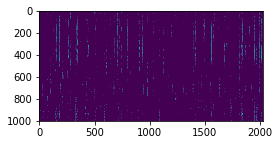

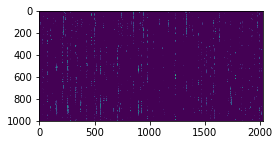

In [19]:
import matplotlib.pyplot as plt
from keras.models import Model

layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(testdata)

plt.imshow(intermediate_output[:1000])
plt.show()

pickle.dump(intermediate_output, open("testdataprocessed5.pickle", "wb"))

intermediate_output = intermediate_layer_model.predict(traindata)

plt.imshow(intermediate_output[:1000])
plt.show()
pickle.dump(intermediate_output, open("traindataprocessed4.pickle", "wb"), protocol=4)

In [41]:
#pickle.dump( traindataProcessed, open("traindataprocessed2.pickle", "wb"))

In [42]:
traindataProcessed.shape

(170000, 512)

In [43]:
#model.save("dataProcessor")

In [7]:
with open("testclasses.pickle", "wb") as file:
    pickle.dump(testclasses, file)
    
with open("trainclasses.pickle", "wb") as file:
    pickle.dump(trainclasses, file)

In [11]:
tdata = UltrasoundData("../../ultrasoundHacks/validation1.pickle")
tdata.makeData()

(8883, 3) (1200,)


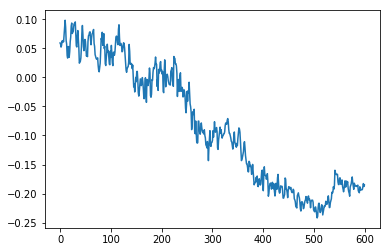

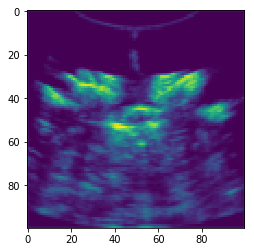

In [12]:
plt.plot(tdata.classes[:600, 0])
plt.show()
plt.imshow(tdata.data[0, :, :, 0])
plt.show()

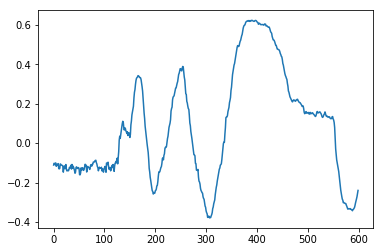

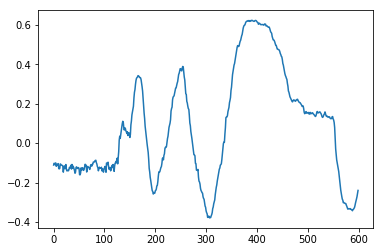

In [10]:
import matplotlib.pyplot as plt
plt.plot(udata.classes[:600, 0])
plt.show()
plt.plot(udata.rawangles[:600])
plt.show()

In [13]:
model.predict(tdata.data)

NameError: name 'model' is not defined

In [30]:
tdata.data.shape

(1200, 100, 100, 1)